In [1]:
%load_ext autoreload
%autoreload 2

# Circuit energy difference 

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


In [4]:
good_cols = list(data.columns)
get_true_interaction_cols = partial(get_true_interaction_cols, num_species=len(data['sample_name'].unique()))
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites')]
binding_idx_map = {e.replace('energies_', ''): i for i, e in enumerate(
    get_true_interaction_cols(data, 'energies'))}

dfm = data[data['sample_name'] == 'RNA_0'].melt(good_cols, value_vars=get_true_interaction_cols(data, 'energies'), value_name='energies', var_name='idx')
dfm

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,name,interacting,self_interacting,...,fold_change_ratio_from_mutation_to_base,initial_steady_states_ratio_from_mutation_to_base,max_amount_ratio_from_mutation_to_base,min_amount_ratio_from_mutation_to_base,overshoot_ratio_from_mutation_to_base,RMSE_ratio_from_mutation_to_base,steady_states_ratio_from_mutation_to_base,sample_name,idx,energies
0,toy_circuit_combo0_100192,ref_circuit,0,[],[],data/generate_seqs_flexible/2023_04_17_205800/...,0.0,toy_circuit_combo0_100192,[[1 2]],[],...,1.000000,1.0,1.0,1.000000,inf,inf,1.000000,RNA_0,energies_0-0,0.00
1,toy_circuit_combo0_100192,RNA_0_m1-0,1,[0],[2],data/generate_seqs_flexible/2023_04_17_205800/...,0.0,toy_circuit_combo0_100192,[[1 2]],[],...,1.000000,1.0,1.0,1.000000,inf,inf,1.000000,RNA_0,energies_0-0,0.00
2,toy_circuit_combo0_100192,RNA_0_m1-1,1,[6],[12],data/generate_seqs_flexible/2023_04_17_205800/...,1.0,toy_circuit_combo0_100192,[[1 2]],[],...,1.000000,1.0,1.0,1.000000,inf,inf,1.000000,RNA_0,energies_0-0,0.00
3,toy_circuit_combo0_100192,RNA_0_m1-2,1,[4],[0],data/generate_seqs_flexible/2023_04_17_205800/...,2.0,toy_circuit_combo0_100192,[[1 2]],[],...,1.000000,1.0,1.0,1.000000,inf,inf,1.000000,RNA_0,energies_0-0,0.00
4,toy_circuit_combo0_100192,RNA_0_m1-3,1,[4],[15],data/generate_seqs_flexible/2023_04_17_205800/...,3.0,toy_circuit_combo0_100192,[[1 2]],[],...,1.000000,1.0,1.0,1.000000,inf,inf,1.000000,RNA_0,energies_0-0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257995,toy_circuit_combo0_999765,RNA_2_m5-5,5,"[8, 11, 3, 3, 7]","[7, 3, 5, 9, 0]",data/generate_seqs_flexible/2023_04_17_205800/...,155.0,toy_circuit_combo0_999765,[],[[0 0]],...,1.000000,1.0,1.0,1.000000,inf,inf,1.000000,RNA_0,energies_2-2,0.00
3257996,toy_circuit_combo0_999765,RNA_2_m5-6,5,"[6, 9, 6, 0, 0]","[0, 13, 17, 11, 1]",data/generate_seqs_flexible/2023_04_17_205800/...,156.0,toy_circuit_combo0_999765,[],[[0 0]],...,1.000000,1.0,1.0,1.000000,inf,inf,1.000000,RNA_0,energies_2-2,0.00
3257997,toy_circuit_combo0_999765,RNA_2_m5-7,5,"[0, 4, 11, 1, 4]","[15, 10, 6, 4, 5]",data/generate_seqs_flexible/2023_04_17_205800/...,157.0,toy_circuit_combo0_999765,[[1 2]],[[0 0]\n [2 2]],...,1.000031,1.0,1.0,1.000031,inf,inf,1.000031,RNA_0,energies_2-2,-12.82
3257998,toy_circuit_combo0_999765,RNA_2_m5-8,5,"[4, 3, 0, 8, 2]","[2, 10, 1, 7, 11]",data/generate_seqs_flexible/2023_04_17_205800/...,158.0,toy_circuit_combo0_999765,[[1 2]],[[0 0]],...,1.000006,1.0,1.0,1.000006,inf,inf,1.000006,RNA_0,energies_2-2,0.00


## Subtract the sum of all other energies from each circuit

In [5]:

def vis_dist(chosen_idx):
    chosen_circuit = dfm[(dfm['circuit_name'] == dfm.iloc[chosen_idx]['circuit_name']) & (dfm['mutation_name'] == dfm.iloc[chosen_idx]['mutation_name'])]
    other_energies = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False)['energies'].apply(lambda x: chosen_circuit['energies'].values - x)
    sns.histplot(dfm, x=other_energies, element='step', log_scale=[False, True])

/tmp/ipykernel_156109/100856472.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  other_energies = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False)['energies'].apply(lambda x: chosen_circuit['energies'].values - x)


circuit_name                                                                       toy_circuit_combo0_100192
mutation_name                                                                                    ref_circuit
mutation_num                                                                                               0
mutation_type                                                                                             []
mutation_positions                                                                                        []
path_to_template_circuit                                   data/generate_seqs_flexible/2023_04_17_205800/...
index                                                                                                    0.0
name                                                                               toy_circuit_combo0_100192
interacting                                                                                          [[1 2]]
self_interacting   

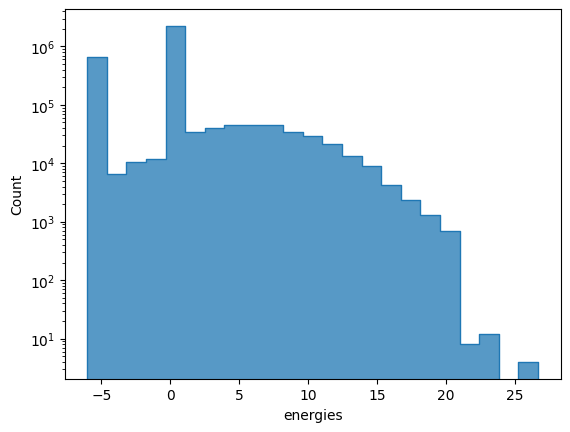

In [6]:
chosen_idx = 0
vis_dist(chosen_idx)

In [10]:
dfm[(dfm['circuit_name'] == dfm.iloc[chosen_idx]['circuit_name']) & (dfm['mutation_name'] == dfm.iloc[chosen_idx]['mutation_name'])][
    ['circuit_name', 'mutation_name', 'mutation_num', 'num_interacting', 'num_self_interacting', 'energies', 'precision', 'precision_diff_to_base_circuit', 'precision_ratio_from_mutation_to_base', 'sensitivity', 'sensitivity_diff_to_base_circuit', 'sensitivity_ratio_from_mutation_to_base', 'sample_name']
]


,circuit_name,mutation_name,mutation_num,num_interacting,num_self_interacting,energies,precision,precision_diff_to_base_circuit,precision_ratio_from_mutation_to_base,sensitivity,sensitivity_diff_to_base_circuit,sensitivity_ratio_from_mutation_to_base,sample_name
0,toy_circuit_combo0_100192,ref_circuit,0,1,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
362000,toy_circuit_combo0_100192,ref_circuit,0,1,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
724000,toy_circuit_combo0_100192,ref_circuit,0,1,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
1086000,toy_circuit_combo0_100192,ref_circuit,0,1,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
1448000,toy_circuit_combo0_100192,ref_circuit,0,1,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
1810000,toy_circuit_combo0_100192,ref_circuit,0,1,0,-6.03,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
2172000,toy_circuit_combo0_100192,ref_circuit,0,1,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
2534000,toy_circuit_combo0_100192,ref_circuit,0,1,0,-6.03,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
2896000,toy_circuit_combo0_100192,ref_circuit,0,1,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0


In [11]:
# dfm[(dfm['other_energies'] < 7) & (dfm['other_energies'] > 6)].iloc[0][['circuit_name', 'mutation_name']]

/tmp/ipykernel_269079/3538420030.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  other_energies2 = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False)['energies'].apply(lambda x: chosen_circuit['energies'].values - x)


<AxesSubplot: xlabel='energies', ylabel='Count'>

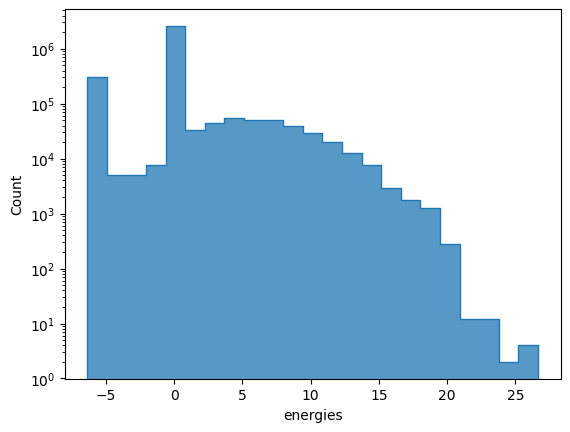

In [ ]:
chosen_idx = 386
vis_dist(chosen_idx)


### Now testing a really strong circuit

In [ ]:
dfm[dfm['energies'] == dfm['energies'].min()].iloc[0][['circuit_name', 'mutation_name']]

circuit_name     toy_circuit_combo0_699423
mutation_name                  RNA_1_m15-8
Name: 600104, dtype: object

/tmp/ipykernel_269079/2884898193.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  other_energies2 = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False)['energies'].apply(lambda x: chosen_circuit['energies'].values - x)


<AxesSubplot: xlabel='energies', ylabel='Count'>

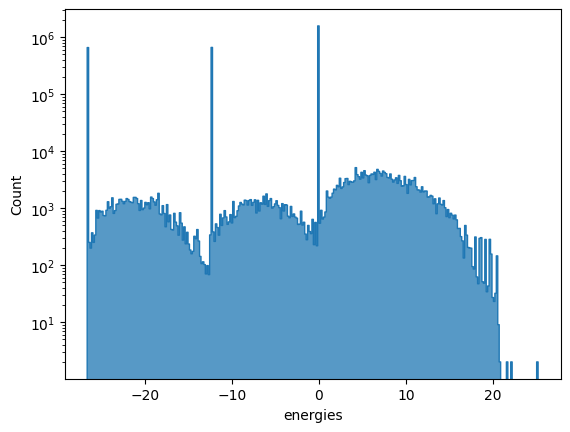

In [ ]:
chosen_idx = 600104
vis_dist(chosen_idx)



In [12]:
chosen_idx = 600104
dfm[(dfm['circuit_name'] == dfm.iloc[chosen_idx]['circuit_name']) & (dfm['mutation_name'] == dfm.iloc[chosen_idx]['mutation_name'])][
    ['circuit_name', 'mutation_name', 'mutation_num', 'num_interacting', 'num_self_interacting', 'energies', 'precision', 'precision_diff_to_base_circuit', 'precision_ratio_from_mutation_to_base', 'sensitivity', 'sensitivity_diff_to_base_circuit', 'sensitivity_ratio_from_mutation_to_base', 'sample_name']
]


,circuit_name,mutation_name,mutation_num,num_interacting,num_self_interacting,energies,precision,precision_diff_to_base_circuit,precision_ratio_from_mutation_to_base,sensitivity,sensitivity_diff_to_base_circuit,sensitivity_ratio_from_mutation_to_base,sample_name
238104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
600104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,-26.67,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
962104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,-12.32,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
1324104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,-26.67,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
1686104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
2048104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
2410104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,-12.32,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
2772104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0
3134104,toy_circuit_combo0_699423,RNA_1_m15-8,15,2,0,0.00,1.0,0.0,1.0,1.0,0.0,1.0,RNA_0


### Now a really weak circuit

In [ ]:
esum = dfm.groupby(['circuit_name', 'mutation_name'], as_index=False)['energies'].agg('sum')
esum[esum['energies'] == 0].iloc[0]

circuit_name     toy_circuit_combo0_100192
mutation_name                  RNA_1_m10-0
energies                               0.0
Name: 70, dtype: object

/tmp/ipykernel_269079/1831746659.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  other_energies2 = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False)['energies'].apply(lambda x: chosen_circuit['energies'].values - x)


<AxesSubplot: xlabel='energies', ylabel='Count'>

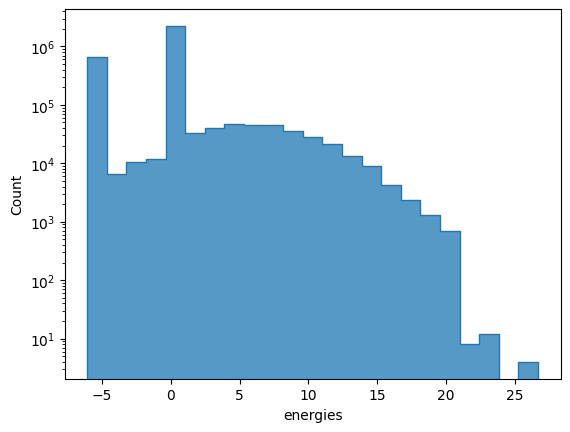

In [ ]:
chosen_idx = 70
vis_dist(chosen_idx)



In [13]:
chosen_idx = 70
dfm[(dfm['circuit_name'] == dfm.iloc[chosen_idx]['circuit_name']) & (dfm['mutation_name'] == dfm.iloc[chosen_idx]['mutation_name'])][
    ['circuit_name', 'mutation_name', 'mutation_num', 'num_interacting', 'num_self_interacting', 'energies', 'precision', 'precision_diff_to_base_circuit', 'precision_ratio_from_mutation_to_base', 'sensitivity', 'sensitivity_diff_to_base_circuit', 'sensitivity_ratio_from_mutation_to_base', 'sample_name']
]


,circuit_name,mutation_name,mutation_num,num_interacting,num_self_interacting,energies,precision,precision_diff_to_base_circuit,precision_ratio_from_mutation_to_base,sensitivity,sensitivity_diff_to_base_circuit,sensitivity_ratio_from_mutation_to_base,sample_name
70,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
362070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
724070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
1086070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
1448070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
1810070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,-6.06,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
2172070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
2534070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,-6.06,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
2896070,toy_circuit_combo0_100192,RNA_1_m1-9,1,1,0,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0


### Now a mid circuit

In [ ]:
dfm[dfm['energies'] <= 0.5 * dfm['energies'].min()].iloc[0][['circuit_name', 'mutation_name']]

circuit_name     toy_circuit_combo0_100248
mutation_name                   RNA_0_m1-4
Name: 186, dtype: object

/tmp/ipykernel_269079/2663251664.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  other_energies2 = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False)['energies'].apply(lambda x: chosen_circuit['energies'].values - x)


186       -15.12
362186      0.00
724186      0.00
1086186     0.00
1448186     0.00
1810186     0.00
2172186     0.00
2534186     0.00
2896186     0.00
Name: energies, dtype: float64

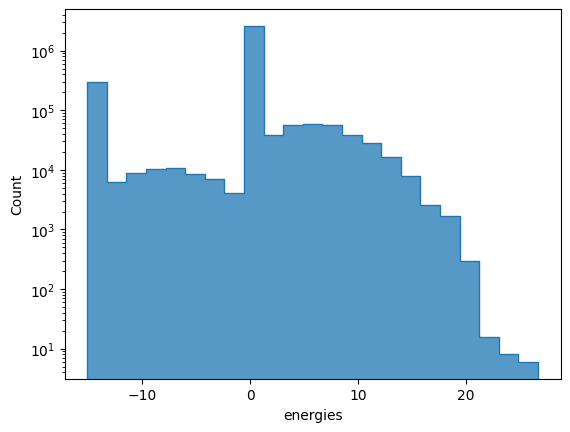

In [ ]:
chosen_idx = 186    
vis_dist(chosen_idx)
dfm[(dfm['circuit_name'] == dfm['circuit_name'].iloc[chosen_idx]) & (dfm['mutation_name'] == dfm['mutation_name'].iloc[chosen_idx])]['energies']

### Now a strong mid circuit

In [ ]:
dfm[dfm['energies'] <= 0.75 * dfm['energies'].min()].iloc[0][['circuit_name', 'mutation_name']]

circuit_name     toy_circuit_combo0_11716
mutation_name                 RNA_0_m15-4
Name: 7808, dtype: object

/tmp/ipykernel_269079/2663251664.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  other_energies2 = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False)['energies'].apply(lambda x: chosen_circuit['energies'].values - x)


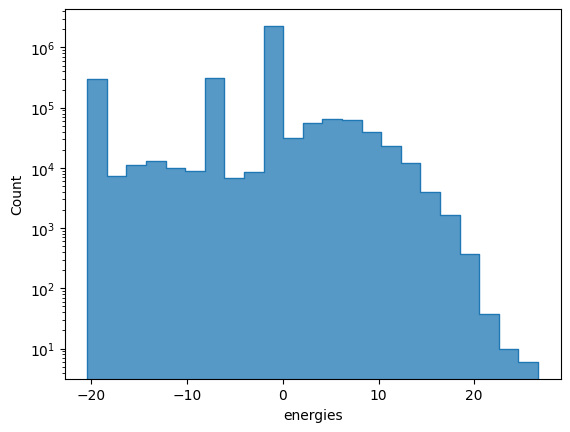

In [ ]:
chosen_idx = 7808    
vis_dist(chosen_idx)


In [14]:
chosen_idx = 7808    
dfm[(dfm['circuit_name'] == dfm.iloc[chosen_idx]['circuit_name']) & (dfm['mutation_name'] == dfm.iloc[chosen_idx]['mutation_name'])][
    ['circuit_name', 'mutation_name', 'mutation_num', 'num_interacting', 'num_self_interacting', 'energies', 'precision', 'precision_diff_to_base_circuit', 'precision_ratio_from_mutation_to_base', 'sensitivity', 'sensitivity_diff_to_base_circuit', 'sensitivity_ratio_from_mutation_to_base', 'sample_name']
]


,circuit_name,mutation_name,mutation_num,num_interacting,num_self_interacting,energies,precision,precision_diff_to_base_circuit,precision_ratio_from_mutation_to_base,sensitivity,sensitivity_diff_to_base_circuit,sensitivity_ratio_from_mutation_to_base,sample_name
7808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,-20.44,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
369808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
731808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
1093808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
1455808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,-6.26,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
1817808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
2179808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
2541808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
2903808,toy_circuit_combo0_11716,RNA_0_m15-4,15,0,2,0.00,1.0,-1.192093e-07,1.0,1.0,5.960465e-08,1.0,RNA_0
